# 105024519 許閔翔
應用多變量分析 HW3

In [1]:
import numpy as np
import pandas as pd

In [2]:
# 利用R-package "mice"補上 missing value，
# 但是仍有無法填補的值以及整欄皆為missing value的欄位，所以將其刪除。 

# import complete dataset.

df = pd.read_csv('DATA/anova_com.csv')
del df["Unnamed: 0"]

print df.shape
print df.head()

df = df.dropna(axis = 0)
print df.shape


(7703, 29)
   PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION   LATITUDE   LONGITUDE    UGDS  \
0        4        4        2       50       1  43.821797  -72.522070  151558   
1        3        4        3        4       6  33.402250 -111.966181  151558   
2        1        2        1       18       3  39.803753  -86.158213   77657   
3        2        3        1       12       5  25.777717  -80.190856   61470   
4        2        2        1       48       6  30.188408  -95.490077   59920   

   UGDS_WHITE  UGDS_BLACK     ...      INC_PCT_H1  INC_PCT_H2  PAR_ED_PCT_HS  \
0      0.6569      0.0411     ...        0.155844    0.298651       0.283797   
1      0.3098      0.1555     ...        0.032588    0.016600       0.483579   
2      0.7054      0.1523     ...        0.051237    0.021793       0.460716   
3      0.0599      0.1657     ...        0.009800    0.003386       0.440310   
4      0.3226      0.1892     ...        0.040525    0.020516       0.446696   

   PAR_ED_PCT_PS    FEMALE 

# Topic1:將G3,G4,G5,G6的資料(X)標準化(Z)後做svd分解

In [3]:
from sklearn.preprocessing import StandardScaler

# Select Featrues in G3, G4, G5, G6
X = df.iloc[:100, 7:]

# Z-normalize df_num
sc = StandardScaler()
Z = sc.fit_transform(X)

# SVD
U, s, V = np.linalg.svd(Z, full_matrices = True)
S = np.zeros((100, 22), dtype=complex)
S[:22, :22] = np.diag(s)

print "USV' = Z ?", np.allclose(Z, np.dot(U, np.dot(S, V)))
print 'U.shape', U.shape
print 'S.shape', S.shape
print 'V.shape', V.shape
print('\nEigenvalues: \n%s' % s)


USV' = Z ? True
U.shape (100, 100)
S.shape (100, 22)
V.shape (22, 22)

Eigenvalues: 
[  3.01126459e+01   2.06755755e+01   1.43558282e+01   1.23792377e+01
   1.09385335e+01   9.60290175e+00   8.77581561e+00   7.47013900e+00
   6.36821249e+00   6.16112295e+00   4.85035494e+00   4.62600090e+00
   3.33460765e+00   2.96384686e+00   2.57032525e+00   2.19212293e+00
   1.79375130e+00   1.22741157e+00   1.07487752e+00   1.04586954e+00
   7.81989274e-09   6.81702854e-15]


將標準化資料(Z)投影到主要和次要的eigenvector(com1, com2)

In [4]:
from numpy.linalg import linalg

# project Z to eigenvector 1 and 2.
data_pro = np.dot(Z, V.T[:, :2])
data_cat = np.array(df.iloc[:100, :7])
result_svd = pd.DataFrame(np.hstack([ data_cat, data_pro ]))
result_svd.columns = ["PREDDEG", "HIGHDEG", "CONTROL", 
                  "ST_FIPS", "REGION", "LATITUDE", "LONGITUDE", 
                  "com1", "com2"]

print result_svd.head()


   PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION   LATITUDE   LONGITUDE  \
0      3.0      4.0      3.0      4.0     6.0  33.402250 -111.966181   
1      1.0      2.0      1.0     18.0     3.0  39.803753  -86.158213   
2      2.0      3.0      1.0     12.0     5.0  25.777717  -80.190856   
3      2.0      2.0      1.0     48.0     6.0  30.188408  -95.490077   
4      2.0      2.0      1.0     48.0     6.0  29.737303  -95.376524   

       com1      com2  
0 -6.678287  2.579147  
1 -2.752622  1.137102  
2 -3.471500 -3.287762  
3 -3.290220 -0.645537  
4 -3.858308 -1.470806  


# 最後決定將"CONTROL"的圖形當作主要想分析討論的主題

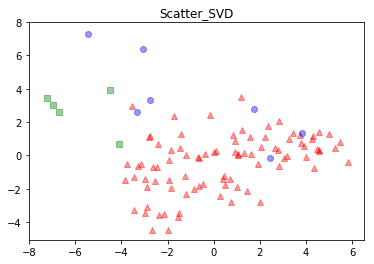

In [5]:
import matplotlib.pyplot as plt
import plotly.plotly as py

fig, ax = plt.subplots()

# 先畫出原本散佈圖的點。
data_1 = np.array(result_svd[result_svd.CONTROL == 1])
data_2 = np.array(result_svd[result_svd.CONTROL == 2])
data_3 = np.array(result_svd[result_svd.CONTROL == 3])
ax.scatter(data_1[:, [7]], data_1[:, [8]], color='r', marker='^', alpha=.4)
ax.scatter(data_2[:, [7]], data_2[:, [8]], color='b', alpha=.4)
ax.scatter(data_3[:, [7]], data_3[:, [8]], color='g', marker='s', alpha=.4)
ax.autoscale()

plt.title('Scatter_SVD')
plt.show()


>觀察上圖，<br/>
看出種類一的數量最多，並解多半集中在右下角。<br/>
而種類二其實算比較分散，但還是大約可以知道都出現在左上。<br/>
而第三種則是集中在左中的位置，自成一群。

>由此可知到人口數前一百名的學校在"CONTROL"的探討中，經過投影之後的資料就可以用視覺化的方式看出分群。
這也使資料的維度被大大減少，讓之後要加入討論的新資料就不需要收集全部變數，在計算複雜度上也能減少許多時間跟硬體空間。

# Topic2:將百分之九十五信心水準的橢圓畫出

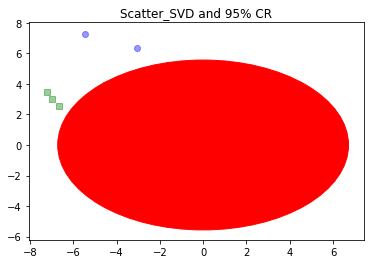

In [6]:
import matplotlib as mpl
import math

fig, ax = plt.subplots()

# 先利用另一種方法畫出原本散佈圖的點。
data_1 = np.array(result_svd[result_svd.CONTROL == 1])
data_2 = np.array(result_svd[result_svd.CONTROL == 2])
data_3 = np.array(result_svd[result_svd.CONTROL == 3])
ax.scatter(data_1[:, [7]], data_1[:, [8]], color='r', marker='^', alpha=.4)
ax.scatter(data_2[:, [7]], data_2[:, [8]], color='b', alpha=.4)
ax.scatter(data_3[:, [7]], data_3[:, [8]], color='g', marker='s', alpha=.4)

# 找出mean, r_x, r_y，再搭配"c"畫出橢圓形。
df_pro = pd.DataFrame(data_pro)
mean = np.array(df_pro.mean())
width = math.sqrt(s[0])*math.sqrt(5.99)
height = math.sqrt(s[1])*math.sqrt(5.99)

ell = mpl.patches.Ellipse(xy=mean, width=width, height=height, color='r')

ax.add_patch(ell)
ax.autoscale()

plt.title('Scatter_SVD and 95% CR')
plt.show()


>觀察上圖，我們利用95%的信心水準找出c平方的值為5.99，<br/>
然後再藉此與我們的主成份與次要成分的eigenvalue畫出橢圓。<br/>
然後從一開始取出的資料中我們原本共有100的點，<br/>
所以畫出的橢圓可以包涵95%的點，也就是剛好剩餘五個點沒被包含到。

>如果之後有別組資料進來，我們也可以利用這個橢圓去比較兩者資料的離散程度。<br/>
如果包涵的點比較多代表資料更集中，反之則比較分散。<br/>

# Topic3: Select Featrues in G3, G4, G5, G6 
# and Do Standardization and PCA

In [7]:
from sklearn.preprocessing import StandardScaler

# Select Featrues in G3, G4, G5, G6
X = df.iloc[:100, 7:]

# Z-normalize data
sc = StandardScaler()
Z = sc.fit_transform(X)

# Estimate the correlation matrix
C = np.dot(Z.T, Z) / X.shape[0]

eigen_vals, eigen_vecs = np.linalg.eigh(C)

print('\nEigenvalues: \n%s' % eigen_vals)


Eigenvalues: 
[ -1.85198389e-16  -2.97467073e-17   1.09384309e-02   1.15536169e-02
   1.50653917e-02   3.21754374e-02   4.80540295e-02   6.60657188e-02
   8.78438822e-02   1.11196082e-01   2.13998843e-01   2.35259430e-01
   3.79594360e-01   4.05541303e-01   5.58029767e-01   7.70149396e-01
   9.22157219e-01   1.19651515e+00   1.53245527e+00   2.06089804e+00
   4.27479424e+00   9.06771440e+00]


# 探討一下選出的components擁有多少的解釋能力

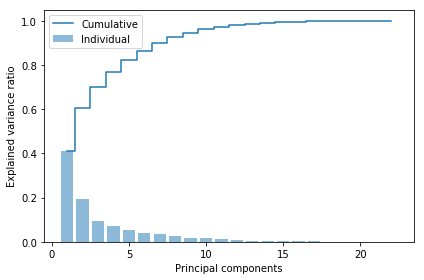

In [8]:
import matplotlib.pyplot as plt

tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

plt.tight_layout()
#plt.savefig('./output/fig-pca-var-exp.png', dpi=300)
plt.show()

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(reverse=True)

# calculate projection matrix
P = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print 'Peojection matrix P:'
print P


Peojection matrix P:
[[-0.12348726  0.08688065]
 [ 0.1839663   0.33723744]
 [-0.19029407  0.09553675]
 [-0.14281424 -0.34449766]
 [ 0.04533508 -0.24426243]
 [-0.10865841  0.16374512]
 [-0.13823946  0.04704478]
 [-0.28057182  0.21131958]
 [ 0.03603585 -0.39507335]
 [-0.27822181 -0.22799147]
 [-0.14701219  0.02866096]
 [ 0.21950138  0.24251312]
 [ 0.28553878  0.2177183 ]
 [ 0.30222496  0.1167041 ]
 [-0.31109499 -0.0681592 ]
 [ 0.29069537  0.15925735]
 [-0.22862874  0.19216368]
 [-0.21603126  0.3064258 ]
 [ 0.28057182 -0.21131958]
 [-0.13215945  0.22932351]
 [ 0.2059418  -0.12404692]
 [-0.2059418   0.12404692]]


# 利用算出的投影矩陣得到"維度為二"的新資料

In [10]:
# calculate new data
Z_pca = Z.dot(P)
data_cat = df.iloc[:100,:7]
result_pca = pd.DataFrame(np.hstack([ data_cat, Z_pca ]))
result_pca.columns = ["PREDDEG", "HIGHDEG", "CONTROL", 
                  "ST_FIPS", "REGION", "LATITUDE", "LONGITUDE", 
                  "com1", "com2"]

print 'PCA Data:'
print result_pca.head()


PCA Data:
   PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION   LATITUDE   LONGITUDE  \
0      3.0      4.0      3.0      4.0     6.0  33.402250 -111.966181   
1      1.0      2.0      1.0     18.0     3.0  39.803753  -86.158213   
2      2.0      3.0      1.0     12.0     5.0  25.777717  -80.190856   
3      2.0      2.0      1.0     48.0     6.0  30.188408  -95.490077   
4      2.0      2.0      1.0     48.0     6.0  29.737303  -95.376524   

       com1      com2  
0 -6.678287  2.579147  
1 -2.752622  1.137102  
2 -3.471500 -3.287762  
3 -3.290220 -0.645537  
4 -3.858308 -1.470806  


# 搭配"CONTROL"畫出減少維度之後的資料

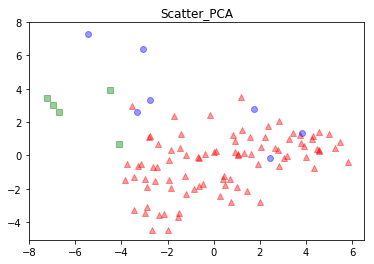

In [11]:
import matplotlib.pyplot as plt
import plotly.plotly as py

fig, ax = plt.subplots()

# 先畫出原本散佈圖的點。
data_1 = np.array(result_pca[result_pca.CONTROL == 1])
data_2 = np.array(result_pca[result_pca.CONTROL == 2])
data_3 = np.array(result_pca[result_pca.CONTROL == 3])
ax.scatter(data_1[:, [7]], data_1[:, [8]], color='r', marker='^', alpha=.4)
ax.scatter(data_2[:, [7]], data_2[:, [8]], color='b', alpha=.4)
ax.scatter(data_3[:, [7]], data_3[:, [8]], color='g', marker='s', alpha=.4)
ax.autoscale()

plt.title('Scatter_PCA')
plt.show()


>與前面svd所畫出的圖形一樣。<br/>
從兩者的原理及推討過程中其實也看出兩者所做的事情大同小異，<br/>
同樣都是在資料Ｘ矩陣中做"column space"的討論，<br/>
只是SVD是直接對整個資料及做分解，而PCA是針對covariance matrix做分解，<br/>
直覺來看可能會認為後者的計算量會比較小，因此也被廣泛運用在資料科學的領域。

>而PCA是一般做資料分析中最常被使用的"data pre-processing"，<br/>
它可以有效地做資料維度的下降，這可以減少計算的複雜度以及GPD的使用，也能減少之後資料量的儲存。<br/>
在物聯網中，除了透過一些處理使資料稀疏，搭配PCA使資料維度下降，可以讓一些資料簡化。<br/>
之後透過簡單的sensor就可以應付處理，以避免所有資料都必須上傳到雲端做處理，來做出即時的分析。